# Imports

In [58]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [59]:
import json
pd.options.display.max_columns = 9999999

In [60]:
data = []

with gzip.open('ucimessages_5_injected_G259200.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [61]:
len(data)

62784

In [62]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 1082008561, 'u': '1', 'v': '2', 'is_fraud': 0, 'history_type': 'G', 'history_size': 259200, 'bip': False, 'cost': 0.0}
{'t': 1082008561, 'u': '1352', 'v': '1685', 'is_fraud': 1, 'history_type': 'G', 'history_size': 259200, 'bip': False, 'cost': 0.0}
{'t': 1082123439, 'u': '3', 'v': '4', 'is_fraud': 0, 'history_type': 'G', 'history_size': 259200, 'bip': False, 'cost': 0.0}
{'t': 1082381991, 'u': '2', 'v': '5', 'is_fraud': 0, 'history_type': 'G', 'history_size': 259200, 'bip': False, 'cost': 0.0, 'number_of_nodes': 4, 'degrees_nb_one': 4, 'degrees_nb_two': 0, 'degrees_min': 1, 'degrees_max': 1, 'degrees_median': 1, 'weighted_degrees_nb_one': 4, 'weighted_degrees_nb_two': 0, 'weighted_degrees_min': 1, 'weighted_degrees_max': 1, 'weighted_degrees_median': 1, 'u_degree': 1, 'v_degree': 1, 'u_same_degree': 4, 'v_same_degree': 4, 'u_greater_degree': 0, 'v_greater_degree': 0, 'u_weighted_degree': 1, 'v_weighted_degree': 1, 'u_same_weighted_degree': 4, 'v_same_weighted_degree': 4, 'u_grea

# Flatten the internal `O(1)` features

In [63]:
from utilitiesMe import flatten_dict

In [64]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [65]:
data_flattened[0]

{'t': 1082008561,
 'u': '1',
 'v': '2',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 259200,
 'bip': False,
 'cost': 0.0}

# Convert flattened json to dataframe

In [66]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [67]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,1082407219,6,7,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,259200,False,0.0,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62780,1098744436,1097,1899,0,G,259200,False,0.0,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62781,1098744603,1899,277,0,G,259200,False,0.0,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62782,1098744711,1624,1878,0,G,259200,False,0.0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


In [68]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,1082407219,6,7,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,259200,False,0.0,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62780,1098744436,1097,1899,0,G,259200,False,0.0,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62781,1098744603,1899,277,0,G,259200,False,0.0,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62782,1098744711,1624,1878,0,G,259200,False,0.0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


In [69]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278400e+04,62784.000000,62784.0,62784.0,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.00000,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000
mean,1.086024e+09,0.047608,259200.0,0.0,639.969672,308.336216,108.223969,1.0,65.277743,1.578519,261.271324,82.186139,1.0,184.223348,1.984358,4.791036,14.754607,90.107596,23.423233,146.549067,49.646278,19.181361,52.662255,42.831573,13.030439,145.559644,61.16497,1094.471910,3013.719198,592.323904,198.148054,1.0,57.386566,1.089470,5.728246,239.946337,256.648269
std,3.186740e+06,0.212936,0.0,0.0,275.754684,107.648100,49.788295,0.0,42.972728,0.493800,99.009362,35.031899,0.0,97.212471,0.515430,4.490001,16.233069,109.757498,54.110641,127.751077,74.312565,26.213305,57.942750,80.006945,41.375903,136.370063,88.09549,601.338878,1862.916265,310.821525,110.192061,0.0,29.172307,0.285423,9.473931,302.723588,261.575444
min,1.082009e+09,0.000000,259200.0,0.0,4.000000,4.000000,0.000000,1.0,1.000000,1.000000,4.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,2.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,259200.0,0.0,469.000000,274.000000,61.000000,1.0,34.000000,1.000000,209.000000,53.000000,1.0,107.000000,2.000000,2.000000,5.000000,17.000000,2.000000,46.000000,6.000000,3.000000,13.000000,3.000000,1.000000,41.000000,8.00000,605.000000,1330.000000,345.000000,111.000000,1.0,35.000000,1.000000,1.000000,17.000000,40.000000
50%,1.085087e+09,0.000000,259200.0,0.0,715.000000,347.000000,125.000000,1.0,57.000000,2.000000,295.000000,93.000000,1.0,170.000000,2.000000,3.000000,11.000000,44.000000,6.000000,107.000000,22.000000,9.000000,34.000000,10.000000,2.000000,101.000000,28.00000,1196.000000,3235.000000,636.000000,215.000000,1.0,59.000000,1.000000,3.000000,87.000000,161.000000
75%,1.086349e+09,0.000000,259200.0,0.0,844.000000,386.000000,146.000000,1.0,79.000000,2.000000,339.000000,109.000000,1.0,259.000000,2.000000,6.000000,19.000000,114.000000,18.000000,211.000000,59.000000,24.000000,73.000000,36.000000,7.000000,214.000000,75.00000,1621.000000,4583.000000,871.000000,293.000000,1.0,82.000000,1.000000,6.000000,348.000000,407.000000
max,1.098745e+09,1.000000,259200.0,0.0,1099.000000,455.000000,220.000000,1.0,184.000000,2.000000,408.000000,144.000000,1.0,424.000000,3.000000,88.000000,184.000000,455.000000,454.000000,647.000000,643.000000,370.000000,424.000000,408.000000,407.000000,695.000000,691.00000,2129.000000,7061.000000,1066.000000,407.000000,1.0,124.000000,2.000000,124.000000,1066.000000,1074.000000


# Remove NaNs

In [70]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082381991,2,5,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,1082407219,6,7,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
5,1082407356,7,8,0,G,259200,False,0.0,5.0,4.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
6,1082408003,10,9,0,G,259200,False,0.0,7.0,6.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
7,1082408053,11,9,0,G,259200,False,0.0,8.0,6.0,2.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,6.0,2.0,2.0,0.0,1.0,2.0,6.0,2.0,2.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
8,1082408788,12,13,0,G,259200,False,0.0,10.0,8.0,2.0,1.0,2.0,1.0,8.0,2.0,1.0,2.0,1.0,1.0,1.0,8.0,8.0,2.0,2.0,1.0,1.0,8.0,8.0,2.0,2.0,6.0,6.0,6.0,0.0,1.0,1.0,1.0,1.0,6.0,0.0
9,1082409354,14,9,0,G,259200,False,0.0,11.0,9.0,1.0,1.0,3.0,1.0,9.0,1.0,1.0,3.0,1.0,1.0,3.0,9.0,1.0,2.0,0.0,1.0,3.0,9.0,1.0,2.0,0.0,7.0,7.0,7.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0


In [71]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,1082381991,2,5,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,1082407219,6,7,0,G,259200,False,0.0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
5,1082407356,7,8,0,G,259200,False,0.0,5.0,4.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
6,1082408003,10,9,0,G,259200,False,0.0,7.0,6.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
7,1082408053,11,9,0,G,259200,False,0.0,8.0,6.0,2.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,6.0,2.0,2.0,0.0,1.0,2.0,6.0,2.0,2.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,259200,False,0.0,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62780,1098744436,1097,1899,0,G,259200,False,0.0,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62781,1098744603,1899,277,0,G,259200,False,0.0,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62782,1098744711,1624,1878,0,G,259200,False,0.0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


In [72]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,259200,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278100e+04,62781.000000,62781.0,62781.0,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.00000,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000
mean,1.086024e+09,0.047594,259200.0,0.0,639.969672,308.336216,108.223969,1.0,65.277743,1.578519,261.271324,82.186139,1.0,184.223348,1.984358,4.791036,14.754607,90.107596,23.423233,146.549067,49.646278,19.181361,52.662255,42.831573,13.030439,145.559644,61.16497,1094.471910,3013.719198,592.323904,198.148054,1.0,57.386566,1.089470,5.728246,239.946337,256.648269
std,3.186697e+06,0.212907,0.0,0.0,275.754684,107.648100,49.788295,0.0,42.972728,0.493800,99.009362,35.031899,0.0,97.212471,0.515430,4.490001,16.233069,109.757498,54.110641,127.751077,74.312565,26.213305,57.942750,80.006945,41.375903,136.370063,88.09549,601.338878,1862.916265,310.821525,110.192061,0.0,29.172307,0.285423,9.473931,302.723588,261.575444
min,1.082382e+09,0.000000,259200.0,0.0,4.000000,4.000000,0.000000,1.0,1.000000,1.000000,4.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,2.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,259200.0,0.0,469.000000,274.000000,61.000000,1.0,34.000000,1.000000,209.000000,53.000000,1.0,107.000000,2.000000,2.000000,5.000000,17.000000,2.000000,46.000000,6.000000,3.000000,13.000000,3.000000,1.000000,41.000000,8.00000,605.000000,1330.000000,345.000000,111.000000,1.0,35.000000,1.000000,1.000000,17.000000,40.000000
50%,1.085087e+09,0.000000,259200.0,0.0,715.000000,347.000000,125.000000,1.0,57.000000,2.000000,295.000000,93.000000,1.0,170.000000,2.000000,3.000000,11.000000,44.000000,6.000000,107.000000,22.000000,9.000000,34.000000,10.000000,2.000000,101.000000,28.00000,1196.000000,3235.000000,636.000000,215.000000,1.0,59.000000,1.000000,3.000000,87.000000,161.000000
75%,1.086349e+09,0.000000,259200.0,0.0,844.000000,386.000000,146.000000,1.0,79.000000,2.000000,339.000000,109.000000,1.0,259.000000,2.000000,6.000000,19.000000,114.000000,18.000000,211.000000,59.000000,24.000000,73.000000,36.000000,7.000000,214.000000,75.00000,1621.000000,4583.000000,871.000000,293.000000,1.0,82.000000,1.000000,6.000000,348.000000,407.000000
max,1.098745e+09,1.000000,259200.0,0.0,1099.000000,455.000000,220.000000,1.0,184.000000,2.000000,408.000000,144.000000,1.0,424.000000,3.000000,88.000000,184.000000,455.000000,454.000000,647.000000,643.000000,370.000000,424.000000,408.000000,407.000000,695.000000,691.00000,2129.000000,7061.000000,1066.000000,407.000000,1.0,124.000000,2.000000,124.000000,1066.000000,1074.000000


In [74]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
5,0,5.0,4.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
6,0,7.0,6.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
7,0,8.0,6.0,2.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,6.0,2.0,2.0,0.0,1.0,2.0,6.0,2.0,2.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62780,0,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62781,0,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62782,0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


In [75]:
df_features.describe()

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000,62781.00000,62781.000000,62781.000000,62781.000000,62781.000000,62781.0,62781.000000,62781.000000,62781.000000,62781.000000,62781.000000
mean,0.047594,639.969672,308.336216,108.223969,1.0,65.277743,1.578519,261.271324,82.186139,1.0,184.223348,1.984358,4.791036,14.754607,90.107596,23.423233,146.549067,49.646278,19.181361,52.662255,42.831573,13.030439,145.559644,61.16497,1094.471910,3013.719198,592.323904,198.148054,1.0,57.386566,1.089470,5.728246,239.946337,256.648269
std,0.212907,275.754684,107.648100,49.788295,0.0,42.972728,0.493800,99.009362,35.031899,0.0,97.212471,0.515430,4.490001,16.233069,109.757498,54.110641,127.751077,74.312565,26.213305,57.942750,80.006945,41.375903,136.370063,88.09549,601.338878,1862.916265,310.821525,110.192061,0.0,29.172307,0.285423,9.473931,302.723588,261.575444
min,0.000000,4.000000,4.000000,0.000000,1.0,1.000000,1.000000,4.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,2.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,469.000000,274.000000,61.000000,1.0,34.000000,1.000000,209.000000,53.000000,1.0,107.000000,2.000000,2.000000,5.000000,17.000000,2.000000,46.000000,6.000000,3.000000,13.000000,3.000000,1.000000,41.000000,8.00000,605.000000,1330.000000,345.000000,111.000000,1.0,35.000000,1.000000,1.000000,17.000000,40.000000
50%,0.000000,715.000000,347.000000,125.000000,1.0,57.000000,2.000000,295.000000,93.000000,1.0,170.000000,2.000000,3.000000,11.000000,44.000000,6.000000,107.000000,22.000000,9.000000,34.000000,10.000000,2.000000,101.000000,28.00000,1196.000000,3235.000000,636.000000,215.000000,1.0,59.000000,1.000000,3.000000,87.000000,161.000000
75%,0.000000,844.000000,386.000000,146.000000,1.0,79.000000,2.000000,339.000000,109.000000,1.0,259.000000,2.000000,6.000000,19.000000,114.000000,18.000000,211.000000,59.000000,24.000000,73.000000,36.000000,7.000000,214.000000,75.00000,1621.000000,4583.000000,871.000000,293.000000,1.0,82.000000,1.000000,6.000000,348.000000,407.000000
max,1.000000,1099.000000,455.000000,220.000000,1.0,184.000000,2.000000,408.000000,144.000000,1.0,424.000000,3.000000,88.000000,184.000000,455.000000,454.000000,647.000000,643.000000,370.000000,424.000000,408.000000,407.000000,695.000000,691.00000,2129.000000,7061.000000,1066.000000,407.000000,1.0,124.000000,2.000000,124.000000,1066.000000,1074.000000


In [76]:
df_target = df["is_fraud"]
df_target

3        0
4        0
5        0
6        0
7        0
        ..
62779    0
62780    0
62781    0
62782    0
62783    0
Name: is_fraud, Length: 62781, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [77]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [78]:
len(train_df) + len(test_df) == len(df)

True

In [79]:
train_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
3,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
4,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
5,0,5.0,4.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
6,0,7.0,6.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
7,0,8.0,6.0,2.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,6.0,2.0,2.0,0.0,1.0,2.0,6.0,2.0,2.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43945,0,930.0,408.0,169.0,1.0,45.0,2.0,346.0,111.0,1.0,197.0,3.0,4.0,9.0,76.0,19.0,182.0,54.0,7.0,47.0,32.0,3.0,258.0,41.0,1536.0,4290.0,819.0,282.0,1.0,45.0,1.0,2.0,282.0,435.0
43946,0,930.0,409.0,169.0,1.0,45.0,2.0,346.0,112.0,1.0,197.0,3.0,5.0,10.0,37.0,7.0,146.0,46.0,8.0,38.0,28.0,4.0,231.0,52.0,1535.0,4288.0,818.0,282.0,1.0,45.0,1.0,1.0,818.0,717.0
43947,0,930.0,409.0,169.0,1.0,45.0,2.0,346.0,113.0,1.0,197.0,3.0,5.0,9.0,37.0,20.0,146.0,53.0,9.0,48.0,20.0,3.0,212.0,39.0,1535.0,4288.0,819.0,280.0,1.0,45.0,1.0,3.0,135.0,301.0
43948,0,930.0,409.0,169.0,1.0,45.0,2.0,346.0,113.0,1.0,197.0,3.0,5.0,11.0,38.0,11.0,146.0,36.0,17.0,39.0,8.0,2.0,125.0,51.0,1536.0,4289.0,820.0,280.0,1.0,45.0,1.0,1.0,820.0,716.0


In [80]:
test_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
43950,0,930.0,408.0,170.0,1.0,45.0,2.0,345.0,113.0,1.0,197.0,3.0,2.0,5.0,170.0,39.0,352.0,146.0,3.0,10.0,61.0,14.0,411.0,199.0,1537.0,4291.0,820.0,281.0,1.0,45.0,1.0,2.0,281.0,436.0
43951,0,930.0,410.0,170.0,1.0,45.0,2.0,345.0,114.0,1.0,196.0,3.0,5.0,11.0,40.0,12.0,144.0,35.0,18.0,40.0,4.0,1.0,122.0,51.0,1531.0,4283.0,813.0,283.0,1.0,45.0,1.0,2.0,283.0,435.0
43952,1,931.0,411.0,172.0,1.0,45.0,2.0,347.0,114.0,1.0,193.0,3.0,1.0,6.0,411.0,33.0,520.0,112.0,1.0,12.0,347.0,14.0,584.0,173.0,1529.0,4263.0,813.0,284.0,1.0,45.0,1.0,1.0,813.0,716.0
43953,1,932.0,411.0,173.0,1.0,45.0,2.0,348.0,113.0,1.0,193.0,3.0,1.0,2.0,411.0,173.0,521.0,348.0,1.0,3.0,348.0,64.0,584.0,407.0,1530.0,4264.0,814.0,284.0,1.0,45.0,1.0,1.0,814.0,716.0
43954,0,932.0,410.0,174.0,1.0,45.0,2.0,347.0,114.0,1.0,193.0,3.0,2.0,6.0,174.0,34.0,348.0,112.0,2.0,10.0,114.0,14.0,471.0,198.0,1531.0,4265.0,815.0,284.0,1.0,45.0,1.0,1.0,815.0,716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62780,0,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62781,0,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62782,0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


### Undersampling and training on `X_train, y_train`

In [81]:
train_df["is_fraud"].value_counts()

0    41844
1     2103
Name: is_fraud, dtype: int64

In [82]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [83]:
print(len(nonanomalous))
print(len(anomalous))

41844
2103


In [84]:
print(nonanomalous.shape)
print(anomalous.shape)

(41844, 34)
(2103, 34)


In [85]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,762.655076,352.887582,125.201678,1.0,81.117603,1.774926,308.861079,93.948332,1.0,227.937458,2.108546,6.076236,18.309244,73.714272,13.031355,162.535465,47.227846,24.844040,67.127211,30.907944,5.371618,154.829677,57.207796,1397.725552,3935.364043,751.406223,250.769525,1.0,70.808551,1.103026,6.481766,274.543806,312.251721
1,759.935806,352.866381,124.374227,1.0,79.940086,1.765097,308.873514,93.592011,1.0,225.426058,2.094627,1.298621,3.601046,306.009510,170.791726,375.273894,261.210651,1.533048,8.374703,263.641940,139.050880,423.348550,310.349976,1385.890157,3896.005706,745.871136,248.362815,1.0,70.721350,1.103661,1.001427,745.620542,639.867332


In [86]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [87]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [88]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
4193,0,496.0,264.0,60.0,1.0,35.0,1.0,239.0,56.0,1.0,203.0,2.0,12.0,21.0,4.0,2.0,33.0,7.0,36.0,123.0,2.0,1.0,36.0,2.0,897.0,2522.0,490.0,157.0,1.0,69.0,1.0,13.0,8.0,23.0
28543,0,869.0,389.0,150.0,1.0,110.0,2.0,355.0,116.0,1.0,236.0,2.0,1.0,20.0,389.0,4.0,480.0,13.0,1.0,55.0,355.0,4.0,514.0,33.0,1588.0,4428.0,890.0,263.0,1.0,98.0,1.0,1.0,890.0,698.0
5758,0,599.0,330.0,63.0,1.0,65.0,1.0,301.0,55.0,1.0,155.0,1.0,7.0,14.0,11.0,3.0,73.0,30.0,26.0,87.0,3.0,1.0,56.0,11.0,1052.0,2808.0,612.0,167.0,1.0,43.0,1.0,10.0,10.0,44.0
41356,0,1019.0,426.0,171.0,1.0,90.0,2.0,375.0,120.0,1.0,377.0,3.0,8.0,10.0,23.0,19.0,104.0,67.0,49.0,60.0,1.0,2.0,56.0,41.0,1970.0,6315.0,983.0,380.0,1.0,95.0,2.0,12.0,17.0,78.0
10606,0,764.0,366.0,116.0,1.0,70.0,2.0,326.0,90.0,1.0,170.0,2.0,8.0,14.0,20.0,6.0,103.0,37.0,32.0,131.0,3.0,3.0,85.0,2.0,1530.0,4295.0,867.0,224.0,1.0,80.0,1.0,6.0,25.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,1,1015.0,419.0,197.0,1.0,59.0,2.0,366.0,119.0,1.0,336.0,3.0,1.0,1.0,419.0,419.0,596.0,596.0,1.0,1.0,366.0,366.0,649.0,649.0,1854.0,5882.0,933.0,343.0,1.0,84.0,1.0,1.0,933.0,921.0
43807,1,997.0,403.0,200.0,1.0,59.0,2.0,350.0,121.0,1.0,330.0,3.0,1.0,1.0,403.0,403.0,594.0,594.0,1.0,1.0,350.0,350.0,647.0,647.0,1808.0,5585.0,919.0,328.0,1.0,61.0,1.0,1.0,919.0,889.0
43830,1,993.0,411.0,192.0,1.0,59.0,2.0,355.0,114.0,1.0,330.0,3.0,1.0,1.0,411.0,411.0,582.0,582.0,1.0,1.0,355.0,355.0,638.0,638.0,1767.0,5357.0,904.0,324.0,1.0,61.0,1.0,1.0,904.0,863.0
43861,1,964.0,401.0,186.0,1.0,48.0,2.0,341.0,117.0,1.0,207.0,3.0,1.0,2.0,401.0,186.0,563.0,377.0,1.0,2.0,341.0,117.0,623.0,506.0,1673.0,4853.0,869.0,317.0,1.0,46.0,1.0,1.0,869.0,804.0


Author: Now the rows of the `nonanomalous` are random

In [89]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    2103
1    2103
Name: is_fraud, dtype: int64

In [90]:
new_dataset.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,761.958155,352.460295,125.218260,1.0,80.244413,1.785544,308.326201,93.715169,1.0,228.539705,2.107941,6.186876,18.193533,75.143604,12.296243,162.793628,46.060865,24.768426,67.176415,30.670946,4.98098,154.17689,55.436995,1393.606277,3921.791726,748.922016,250.291488,1.0,71.196386,1.102710,6.508797,263.017594,305.587256
1,759.935806,352.866381,124.374227,1.0,79.940086,1.765097,308.873514,93.592011,1.0,225.426058,2.094627,1.298621,3.601046,306.009510,170.791726,375.273894,261.210651,1.533048,8.374703,263.641940,139.05088,423.34855,310.349976,1385.890157,3896.005706,745.871136,248.362815,1.0,70.721350,1.103661,1.001427,745.620542,639.867332


In [91]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
4193,0,496.0,264.0,60.0,1.0,35.0,1.0,239.0,56.0,1.0,203.0,2.0,12.0,21.0,4.0,2.0,33.0,7.0,36.0,123.0,2.0,1.0,36.0,2.0,897.0,2522.0,490.0,157.0,1.0,69.0,1.0,13.0,8.0,23.0
28543,0,869.0,389.0,150.0,1.0,110.0,2.0,355.0,116.0,1.0,236.0,2.0,1.0,20.0,389.0,4.0,480.0,13.0,1.0,55.0,355.0,4.0,514.0,33.0,1588.0,4428.0,890.0,263.0,1.0,98.0,1.0,1.0,890.0,698.0
5758,0,599.0,330.0,63.0,1.0,65.0,1.0,301.0,55.0,1.0,155.0,1.0,7.0,14.0,11.0,3.0,73.0,30.0,26.0,87.0,3.0,1.0,56.0,11.0,1052.0,2808.0,612.0,167.0,1.0,43.0,1.0,10.0,10.0,44.0
41356,0,1019.0,426.0,171.0,1.0,90.0,2.0,375.0,120.0,1.0,377.0,3.0,8.0,10.0,23.0,19.0,104.0,67.0,49.0,60.0,1.0,2.0,56.0,41.0,1970.0,6315.0,983.0,380.0,1.0,95.0,2.0,12.0,17.0,78.0
10606,0,764.0,366.0,116.0,1.0,70.0,2.0,326.0,90.0,1.0,170.0,2.0,8.0,14.0,20.0,6.0,103.0,37.0,32.0,131.0,3.0,3.0,85.0,2.0,1530.0,4295.0,867.0,224.0,1.0,80.0,1.0,6.0,25.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,1,1015.0,419.0,197.0,1.0,59.0,2.0,366.0,119.0,1.0,336.0,3.0,1.0,1.0,419.0,419.0,596.0,596.0,1.0,1.0,366.0,366.0,649.0,649.0,1854.0,5882.0,933.0,343.0,1.0,84.0,1.0,1.0,933.0,921.0
43807,1,997.0,403.0,200.0,1.0,59.0,2.0,350.0,121.0,1.0,330.0,3.0,1.0,1.0,403.0,403.0,594.0,594.0,1.0,1.0,350.0,350.0,647.0,647.0,1808.0,5585.0,919.0,328.0,1.0,61.0,1.0,1.0,919.0,889.0
43830,1,993.0,411.0,192.0,1.0,59.0,2.0,355.0,114.0,1.0,330.0,3.0,1.0,1.0,411.0,411.0,582.0,582.0,1.0,1.0,355.0,355.0,638.0,638.0,1767.0,5357.0,904.0,324.0,1.0,61.0,1.0,1.0,904.0,863.0
43861,1,964.0,401.0,186.0,1.0,48.0,2.0,341.0,117.0,1.0,207.0,3.0,1.0,2.0,401.0,186.0,563.0,377.0,1.0,2.0,341.0,117.0,623.0,506.0,1673.0,4853.0,869.0,317.0,1.0,46.0,1.0,1.0,869.0,804.0


In [92]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
2912,0,395.0,218.0,50.0,1.0,34.0,1.0,200.0,36.0,1.0,159.0,1.0,3.0,5.0,26.0,15.0,101.0,64.0,6.0,17.0,5.0,4.0,106.0,58.0,646.0,1773.0,365.0,106.0,1.0,63.0,1.0,3.0,49.0,126.0
26126,0,731.0,352.0,122.0,1.0,77.0,2.0,299.0,108.0,1.0,146.0,2.0,9.0,10.0,9.0,8.0,42.0,34.0,14.0,20.0,7.0,9.0,113.0,77.0,1201.0,3143.0,674.0,215.0,1.0,53.0,1.0,1.0,674.0,527.0
33853,1,873.0,405.0,151.0,1.0,41.0,2.0,343.0,95.0,1.0,365.0,2.0,1.0,1.0,405.0,405.0,468.0,468.0,1.0,1.0,343.0,343.0,530.0,530.0,1487.0,4413.0,762.0,280.0,1.0,75.0,1.0,1.0,762.0,725.0
33896,1,864.0,406.0,144.0,1.0,41.0,2.0,344.0,91.0,1.0,381.0,2.0,2.0,13.0,144.0,11.0,314.0,28.0,2.0,44.0,91.0,4.0,429.0,40.0,1464.0,4355.0,749.0,276.0,1.0,74.0,1.0,1.0,749.0,715.0
42753,1,1095.0,453.0,195.0,1.0,74.0,2.0,405.0,142.0,1.0,325.0,3.0,1.0,8.0,453.0,21.0,642.0,116.0,1.0,19.0,405.0,4.0,690.0,175.0,2119.0,6977.0,1063.0,389.0,1.0,95.0,1.0,1.0,1063.0,1056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27657,1,816.0,375.0,139.0,1.0,108.0,2.0,331.0,111.0,1.0,203.0,2.0,1.0,1.0,375.0,375.0,441.0,441.0,1.0,1.0,331.0,331.0,485.0,485.0,1447.0,3868.0,817.0,239.0,1.0,84.0,1.0,1.0,817.0,630.0
11434,0,804.0,381.0,124.0,1.0,70.0,2.0,340.0,101.0,1.0,186.0,2.0,3.0,13.0,56.0,8.0,243.0,51.0,5.0,34.0,23.0,5.0,258.0,81.0,1659.0,4775.0,920.0,260.0,1.0,92.0,1.0,3.0,150.0,329.0
20940,1,745.0,347.0,118.0,1.0,57.0,2.0,296.0,95.0,1.0,170.0,2.0,1.0,1.0,347.0,347.0,398.0,398.0,1.0,1.0,296.0,296.0,449.0,449.0,1328.0,3886.0,672.0,225.0,1.0,59.0,1.0,1.0,672.0,656.0
34529,1,785.0,388.0,124.0,1.0,35.0,2.0,315.0,97.0,1.0,320.0,2.0,1.0,6.0,388.0,30.0,397.0,84.0,1.0,14.0,315.0,10.0,470.0,118.0,1221.0,3387.0,639.0,240.0,1.0,82.0,1.0,1.0,639.0,582.0


In [93]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [94]:
test_df["is_fraud"].value_counts()

0    17949
1      885
Name: is_fraud, dtype: int64

In [95]:
test_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,353.688116,204.193214,68.640871,1.0,28.438353,1.121567,150.062900,54.724386,1.0,82.464260,1.696975,2.388712,8.416848,97.564544,24.562483,82.439412,27.640370,8.940888,26.594685,39.579809,11.708229,88.592568,36.419243,387.861385,866.921054,221.524597,75.570338,1.0,26.066132,1.058165,4.758538,100.723550,86.461864
1,360.343503,208.232768,69.916384,1.0,28.658757,1.116384,153.505085,55.911864,1.0,83.264407,1.679096,1.046328,1.728814,200.927684,141.472316,147.409040,107.568362,1.070056,2.664407,147.841808,102.507345,202.527684,158.011299,394.759322,880.526554,226.138983,76.851977,1.0,26.310734,1.049718,1.000000,226.138983,168.620339


In [96]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [97]:
test_df["is_fraud"].value_counts()

0    17949
1      885
Name: is_fraud, dtype: int64

In [98]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9509


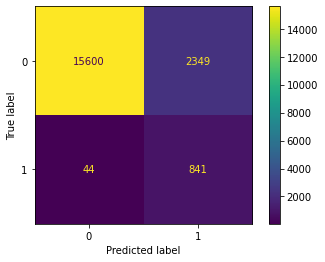

In [99]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

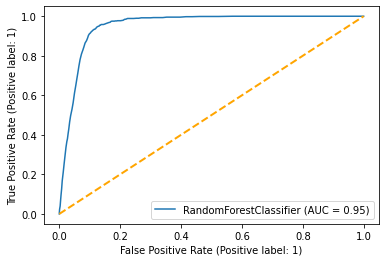

In [100]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [101]:
df.reset_index(drop=True, inplace=True)

In [102]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [103]:
X

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
2,5.0,4.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
3,7.0,6.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,4.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,4.0,0.0
4,8.0,6.0,2.0,1.0,2.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,6.0,2.0,2.0,0.0,1.0,2.0,6.0,2.0,2.0,0.0,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62776,81.0,67.0,11.0,1.0,24.0,1.0,48.0,14.0,1.0,24.0,1.0,1.0,24.0,67.0,1.0,14.0,0.0,1.0,24.0,48.0,1.0,33.0,0.0,61.0,92.0,43.0,11.0,1.0,6.0,1.0,1.0,43.0,18.0
62777,82.0,68.0,11.0,1.0,25.0,1.0,49.0,14.0,1.0,25.0,1.0,1.0,25.0,68.0,1.0,14.0,0.0,1.0,25.0,49.0,1.0,33.0,0.0,62.0,93.0,44.0,11.0,1.0,6.0,1.0,1.0,44.0,18.0
62778,83.0,69.0,11.0,1.0,26.0,1.0,50.0,14.0,1.0,26.0,1.0,1.0,26.0,69.0,1.0,14.0,0.0,1.0,26.0,50.0,1.0,33.0,0.0,63.0,94.0,45.0,11.0,1.0,6.0,1.0,1.0,45.0,18.0
62779,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0


In [104]:
y

0        0
1        0
2        0
3        0
4        0
        ..
62776    0
62777    0
62778    0
62779    0
62780    0
Name: is_fraud, Length: 62781, dtype: int64

In [105]:
len(df) / 2

31390.5

In [106]:
8353+8350

16703

In [107]:
len(df)

62781

In [108]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 627 



In [109]:
len(df)

62781

In [110]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 627 

RangeIndex(start=0, stop=31390, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1198, 1198
Counts of y = 1 and y = 0 in y_test: 323, 5955
0
Iteration difference 31390: ROC-AUC=0.9770
------------------------------------------------------------------------------------------------
RangeIndex(start=627, stop=32017, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1205, 1205
Counts of y = 1 and y = 0 in y_test: 324, 5954
627
Iteration difference 31390: ROC-AUC=0.9785
------------------------------------------------------------------------------------------------
RangeIndex(start=1254, stop=32644, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1208, 1208
Counts of y = 1 and y = 0 in y_test: 315, 5963
1254
Iteration difference 31390: ROC-AUC=0.9793
------------------------------------------------------------------------------------------------
RangeIndex(start=1881, stop=33271, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1216, 1216

16929
Iteration difference 31390: ROC-AUC=0.9291
------------------------------------------------------------------------------------------------
RangeIndex(start=17556, stop=48946, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1216, 1216
Counts of y = 1 and y = 0 in y_test: 305, 5973
17556
Iteration difference 31390: ROC-AUC=0.9219
------------------------------------------------------------------------------------------------
RangeIndex(start=18183, stop=49573, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1220, 1220
Counts of y = 1 and y = 0 in y_test: 301, 5977
18183
Iteration difference 31390: ROC-AUC=0.9242
------------------------------------------------------------------------------------------------
RangeIndex(start=18810, stop=50200, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1223, 1223
Counts of y = 1 and y = 0 in y_test: 304, 5974
18810
Iteration difference 31390: ROC-AUC=0.9403
---------------------------------------------------

In [111]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
62779,1098744711,1624,1878,0,G,259200,False,0.0,85.0,71.0,11.0,1.0,26.0,1.0,52.0,14.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,1.0,1.0,52.0,52.0,33.0,33.0,64.0,95.0,46.0,11.0,1.0,6.0,1.0,1.0,46.0,18.0
62780,1098744742,1624,1878,0,G,259200,False,0.0,85.0,71.0,11.0,1.0,26.0,1.0,50.0,16.0,1.0,26.0,1.0,1.0,1.0,71.0,71.0,14.0,14.0,2.0,2.0,16.0,16.0,19.0,19.0,64.0,96.0,45.0,12.0,1.0,6.0,1.0,2.0,12.0,7.0


In [112]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("UCIMessages-5Perc-G259200-AUCInSlidingWindow.xlsx", index=False)

In [113]:
len(roc_auc_results)

51

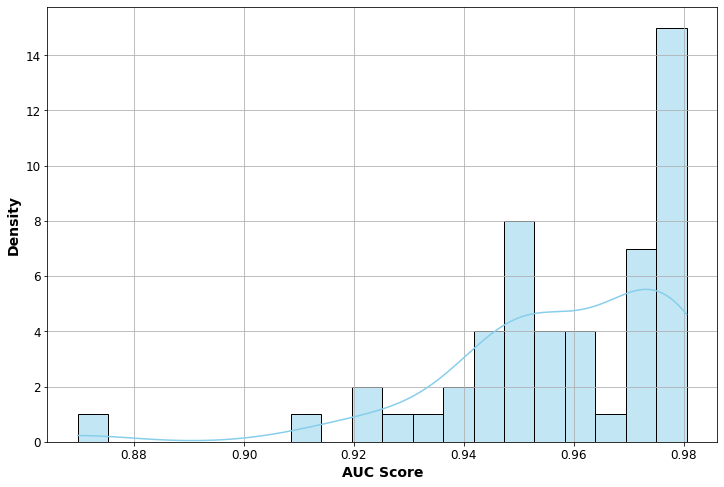

In [114]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()